<a href="https://colab.research.google.com/github/Saadman/tensorflow2.0_projects/blob/master/Deploy_Models_Using_TensorFlow_Serving.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STEP #0: PROBLEM STATEMENT

- In this project, we will build, train and test a model to classify fashion items using TensorFlow 2.0 similar to what we have already done in the past
- What's new is that we are going to deploy the model in practice using Tensorflow Serving.
- Fashion training set consists of 70,000 images divided into 60,000 training and 10,000 testing samples. Dataset sample consists of 28x28 grayscale image, associated with a label from 10 classes. 

- The 10 classes are as follows:  
  - 0 => T-shirt/top
  - 1 => Trouser
  - 2 => Pullover
  - 3 => Dress
  - 4 => Coat
  - 5 => Sandal
  - 6 => Shirt
  - 7 => Sneaker
  - 8 => Bag
  - 9 => Ankle boot

- Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255. 

- Note: TF serving code section is based upon the TensorFlow 2.0 Documentation: https://www.tensorflow.org/tfx/serving/tutorials/Serving_REST_simple 

## STEP #1: IMPORT PACKAGES

In [1]:
import tensorflow as tf
import random
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import tempfile


# STEP #2: IMPORT DATASET

In [2]:
# import Fashion MNIST Dataset using Keras 
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [0]:
# Data Normalization -> Between 0 and 1 
X_train = X_train / 255.0
X_test = X_test / 255.0


In [4]:
X_train.shape

(60000, 28, 28)

In [5]:
X_test.shape

(10000, 28, 28)

In [0]:
# Reshape training data to be = (60000, 28, 28, 1) instead of (60000, 28,28)
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)


In [7]:
X_train.shape

(60000, 28, 28, 1)

In [0]:
# Do the same for the testing dataset
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

In [9]:
X_test.shape

(10000, 28, 28, 1)

In [0]:

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [11]:
len(X_train)

60000

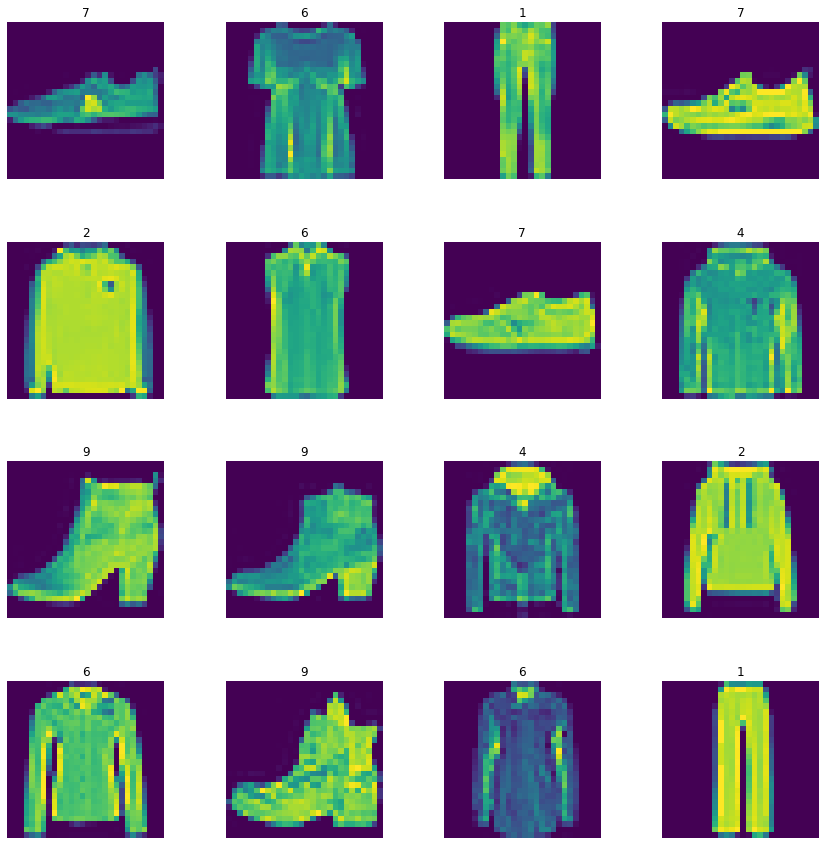

In [12]:
W_grid = 4
L_grid = 4

fig, axes = plt.subplots(L_grid, W_grid, figsize = (15, 15))
axes = axes.ravel()

n_training = len(X_train)

for i in np.arange(0, L_grid * W_grid):
    index = np.random.randint(0, n_training) # pick a random number
    axes[i].imshow(X_train[index].reshape(28,28))
    axes[i].set_title(y_train[index])
    axes[i].axis('off')
    
plt.subplots_adjust(hspace = 0.4)

# STEP #3: BUILD, TRAIN AND TEST THE MODEL

In [13]:
cnn = tf.keras.models.Sequential()

cnn.add(tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (28,28,1)))
cnn.add(tf.keras.layers.MaxPooling2D(2,2))

cnn.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))

cnn.add(tf.keras.layers.Flatten())

cnn.add(tf.keras.layers.Dense(64, activation = 'relu'))

cnn.add(tf.keras.layers.Dense(10, activation = 'softmax'))
cnn.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
flatten (Flatten)            (None, 7744)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                495680    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 515,146
Trainable params: 5

In [0]:
epochs = 5

cnn.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [15]:
cnn.fit(X_train, y_train, epochs=epochs)

test_loss, test_acc = cnn.evaluate(X_test, y_test)
print('\nTest accuracy: {}'.format(test_acc))

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 11s 182us/sample - loss: 0.4041 - acc: 0.8547
Epoch 2/5
60000/60000 [==============================] - 5s 82us/sample - loss: 0.2637 - acc: 0.9042
Epoch 3/5
60000/60000 [==============================] - 5s 83us/sample - loss: 0.2193 - acc: 0.9196
Epoch 4/5
60000/60000 [==============================] - 5s 83us/sample - loss: 0.1841 - acc: 0.9330
Epoch 5/5
10000/10000 [==============================] - 1s 53us/sample - loss: 0.2518 - acc: 0.9135

Test accuracy: 0.9135000109672546


# STEP #4: SAVE THE MODEL

- We now need to save our trained model and it has to be saved in a SavedModel format.
- The model will have a version number and will be saved in a structured directory 
- tf.saved_model.simple_save is a function used to build a saved model that is suitable for serving using Tensorflow Serving. 
- After the model is saved, we can now use TensorFlow Serving to start making inference requests using a specific version of our trained model "servable".
- Use SavedModel to save and load your model—variables, the graph, and the graph's metadata. 
- This is a language-neutral, recoverable, hermetic serialization format that enables higher-level systems and tools to produce, consume, and transform TensorFlow models.
- simple_save offers a very easy way to save a model as follows: 

  - simple_save(session,
            export_dir,
            inputs={"x": x, "y": y},
            outputs={"z": z})
            
- Check this out for more information: 
https://www.tensorflow.org/guide/saved_model

In [0]:
# Let's obtain a temporary storage directory
MODEL_DIR = tempfile.gettempdir()

In [17]:
MODEL_DIR

'/tmp'

In [0]:
# Let's specify the model version, choose #1 for now 
version = 1 

In [19]:
# Let's join the temp model directory with our chosen version number 
# The expected result will be = '\tmp\version number'
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

export_path = /tmp/1



In [20]:
# Let's save the model using simple_save
# If the directory already exists, we will remove it using '!rm' 
# rm removes each file specified on the command line. 

if os.path.isdir(export_path):
  print('\nAlready saved a model, cleaning up\n')
  !rm -r {export_path}

tf.saved_model.simple_save(
    tf.keras.backend.get_session(),
    export_path,
    inputs={'input_image': cnn.input},
    outputs={t.name:t for t in cnn.outputs})


Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.simple_save.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: /tmp/1/saved_model.pb


In [21]:
!ls -l {export_path}

total 100
-rw-r--r-- 1 root root 97603 Jan  4 22:03 saved_model.pb
drwxr-xr-x 2 root root  4096 Jan  4 22:03 variables


# STEP #5: EXPLORE OUR SAVED MODEL

- saved_model_cli will be used to explore MetaGraphDefs (the models) and SignatureDefs (the methods you can call) in our SavedModel. 
- A MetaGraph is a dataflow graph, plus its associated variables, assets, and signatures. 
- A signature is the set of inputs to and outputs from a graph.

In [22]:
# Now we can view our saved model
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_image'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28, 1)
        name: conv2d_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_1/Softmax:0'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: dense_1/Softmax:0
  Method name is: tensorflow/serving/predict


# STEP #6: SERVE THE MODEL USING TENSORFLOW SERVING

  # STEP 6.1: Let's add tensorflow-model-server package to our list of packages 

In [23]:
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  19885      0 --:--:-- --:--:-- --:--:-- 19885
OK
Hit:1 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:5 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:6 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,012 B]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:9 https://cloud

# Step 6.2: Let's install tensorflow model server:

In [24]:
!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  tensorflow-model-server
0 upgraded, 1 newly installed, 0 to remove and 19 not upgraded.
Need to get 140 MB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 tensorflow-model-server all 2.0.0 [140 MB]
Fetched 140 MB in 2s (79.9 MB/s)
Selecting previously unselected package tensorflow-model-server.
(Reading database ... 145674 files and directories currently installed.)
Preparing to unpack .../tensorflow-model-server_2.0.0_all.deb ...
Unpacking tensorflow-model-server (2.0.0) ...
Setting up tensorflow-model-server (2.0.0) ...


# Step 6.3: Let's run TensorFlow serving

- We will load our model and start making inferences (predictions) based on it.
- There are some important parameters:

  - rest_api_port: The port that you'll use for REST requests.
  - model_name: You'll use this in the URL of REST requests. You can choose any name
  - model_base_path: This is the path to the directory where you've saved your model.
  
- For more information regarding REST, check this out: 
https://www.codecademy.com/articles/what-is-rest
- REST is a revival of HTTP in which http commands have semantic meaning. 

In [0]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [26]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=fashion_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1


Starting job # 0 in a separate thread.


In [27]:
!tail server.log

2020-01-04 22:04:15.057828: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:54] Reading meta graph with tags { serve }
2020-01-04 22:04:15.059295: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2020-01-04 22:04:15.070009: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:202] Restoring SavedModel bundle.
2020-01-04 22:04:15.089834: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:311] SavedModel load for tags { serve }; Status: success. Took 33734 microseconds.
2020-01-04 22:04:15.090264: I tensorflow_serving/servables/tensorflow/saved_model_warmup.cc:105] No warmup data file found at /tmp/1/assets.extra/tf_serving_warmup_requests
2020-01-04 22:04:15.090341: I tensorflow_serving/core/loader_harness.cc:87] Successfully loaded servable version {name: fashion_model version: 1}
2020-01-04 22:04:15.091233: I tensorflow_serv

- **Congratulations! now we have successfully loaded a servable version of our model {name: fashion_model version: 1}** 

# STEP 6.4: Let's start making requests in TensorFlow Serving

In [0]:
def show(idx, title):
  plt.figure()
  plt.imshow(X_test[idx].reshape(28,28))
  plt.title('\n\n{}'.format(title), fontdict={'size': 16})


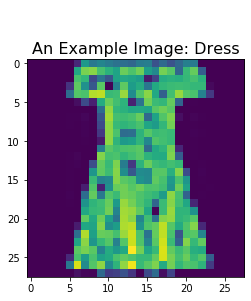

In [29]:
rando = random.randint(0,len(X_test)-1)
show(rando, 'An Example Image: {}'.format(class_names[y_test[rando]]))

In [30]:
# Let's create a JSON object and make 3 inference requests
data = json.dumps({"signature_name": "serving_default", "instances": X_test[0:3].tolist()})
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

Data: {"signature_name": "serving_default", "instances": ...  [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]]]}


In [0]:
!pip install -q requests


In [0]:

import requests


In [0]:
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/fashion_model:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']


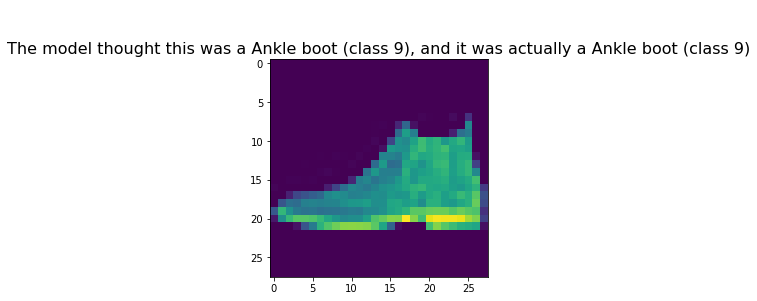

In [34]:

show(0, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
  class_names[np.argmax(predictions[0])], y_test[0], class_names[np.argmax(predictions[0])], y_test[0]))

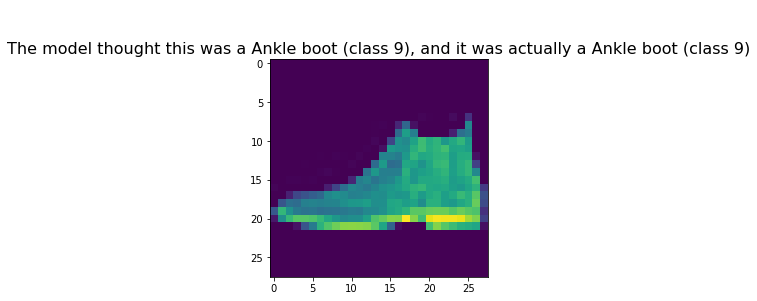

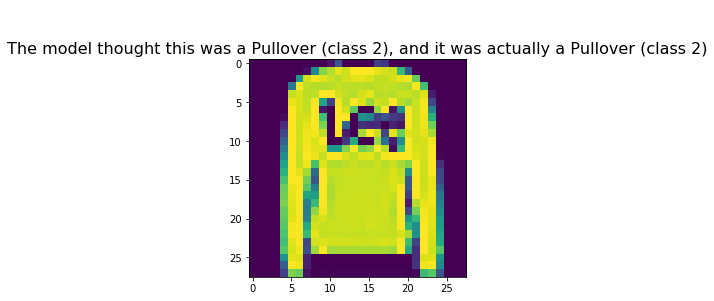

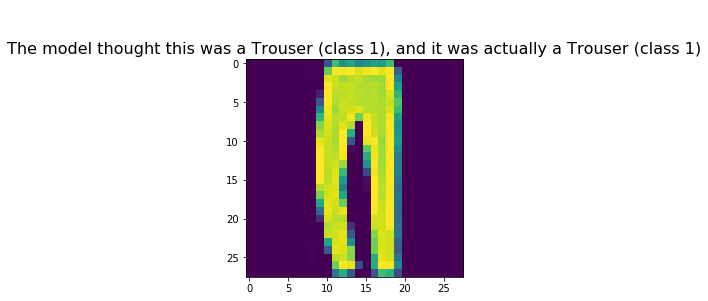

In [35]:
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/fashion_model/versions/1:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

for i in range(0,3):
  show(i, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
    class_names[np.argmax(predictions[i])], y_test[i], class_names[np.argmax(predictions[i])], y_test[i]))